In [ ]:
from glob import glob
import pathlib

import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import time
print(tf.config.list_physical_devices('GPU'))
import tensorflow.keras as keras
import numpy as np
from IPython import display
from skimage.transform import resize
import os
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


In [ ]:
input_shape = (224, 224, 3)  # Assuming input images have this shape
BATCH_SIZE    = 10
R_LOSS_FACTOR = 10000
EPOCHS        = 100
INITIAL_EPOCH = 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Define paths for input and output directories
base_dir = '/content/drive/MyDrive/data_depth_selection/depth_selection'
train_dir = os.path.join(base_dir, 'test_depth_completion_anonymous')
val_dir = os.path.join(base_dir, 'val_selection_cropped')

X_FOLDER      = os.path.join(train_dir, 'image')
Y_FOLDER      = os.path.join(train_dir, 'velodyne_raw')
TEST_X_FOLDER      = os.path.join(val_dir, 'image')
TEST_Y_FOLDER      = os.path.join(val_dir, 'velodyne_raw')

In [ ]:
xfiles  = glob(os.path.join(X_FOLDER, '*.png'))
yfiles  = glob(os.path.join(Y_FOLDER, '*.png'))
xfiles.sort()
yfiles.sort()
xfiles=np.array(xfiles)
yfiles=np.array(yfiles)

testxfiles  = glob(os.path.join(TEST_X_FOLDER, '*.png'))
testyfiles  = glob(os.path.join(TEST_Y_FOLDER, '*.png'))
testxfiles.sort()
testyfiles.sort()
testxfiles=np.array(testxfiles)
testyfiles=np.array(testyfiles)

In [ ]:
[print(x, y) for x,y in zip(xfiles[:5],yfiles[:5])];
[print(x, y) for x,y in zip(testxfiles[:5],testyfiles[:5])];

/data_depth_selection/depth_selection/test_depth_completion_anonymous/image/0000000000.png /data_depth_selection/depth_selection/test_depth_completion_anonymous/velodyne_raw/0000000000.png
/data_depth_selection/depth_selection/test_depth_completion_anonymous/image/0000000001.png /data_depth_selection/depth_selection/test_depth_completion_anonymous/velodyne_raw/0000000001.png
/data_depth_selection/depth_selection/test_depth_completion_anonymous/image/0000000002.png /data_depth_selection/depth_selection/test_depth_completion_anonymous/velodyne_raw/0000000002.png
/data_depth_selection/depth_selection/test_depth_completion_anonymous/image/0000000003.png /data_depth_selection/depth_selection/test_depth_completion_anonymous/velodyne_raw/0000000003.png
/data_depth_selection/depth_selection/test_depth_completion_anonymous/image/0000000004.png /data_depth_selection/depth_selection/test_depth_completion_anonymous/velodyne_raw/0000000004.png
/data_depth_selection/depth_selection/val_selection_cro

In [ ]:
BUFFER_SIZE      = len(xfiles)
TEST_SIZE      = len(testxfiles)
steps_per_epoch  = BUFFER_SIZE // BATCH_SIZE
print('num image files : ', BUFFER_SIZE)
print('steps per epoch : ', steps_per_epoch )

num image files :  1000
steps per epoch :  100


In [ ]:
def load_images(xfile, yfile, flip=True):
    '''
    Lee par de imagenes jpeg y las reescala la tamaño deseado

    Aumantación: Flip horizontal aleatorio, sincronizado
    '''

    xim = tf.io.read_file(xfile)
    xim = tf.image.decode_jpeg(xim)
    xim = tf.cast(xim, tf.float32)
    xim = xim/127.5-1

    # en caso de ser necesario cambiar las dimensiones de la imagen x al leerla
    xim = tf.image.resize(xim, input_shape[:2],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    yim = tf.io.read_file(yfile)
    yim = tf.image.decode_jpeg(yim)
    if tf.shape(yim)[-1] == 1:
        yim = tf.image.grayscale_to_rgb(yim)  # Convert grayscale to RGB
    yim = tf.cast(yim, tf.float32)
    yim = yim/127.5-1

    # en caso de ser necesario cambiar las dimensiones de la imagen y al leerla
    yim = tf.image.resize(yim, input_shape[:2],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)


    # Aumentación sincronizada de dada imágen del par $(x,y)$, en este caso solo un flip der-izq
    if flip and tf.random.uniform(()) > 0.5:
        xim = tf.image.flip_left_right(xim)
        yim = tf.image.flip_left_right(yim)

    return xim, yim

In [ ]:
def display_images(x_imgs=None, y_imgs=None, rows=4, cols=3, offset=0):
    '''
    Despliega pares de imágenes tomando una de cada lista
    '''
    plt.figure(figsize=(cols*5,rows*2.5))
    for i in range(rows*cols):
        plt.subplot(rows, cols*2, 2*i+1)
        plt.imshow((x_imgs[i+offset]+1)/2)
        plt.axis('off')

        plt.subplot(rows, cols*2,2*i+2)
        plt.imshow((y_imgs[i+offset]+1)/2)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
rows=2
cols=2

x_imgs=[]
y_imgs=[]

for i in range(rows*cols):
    xim, yim = load_images(xfiles[i], yfiles[i])
    x_imgs.append(xim)
    y_imgs.append(yim)

print(x_imgs[0].shape, x_imgs[0].shape) # a modo de comprobacion

(224, 224, 3) (224, 224, 3)


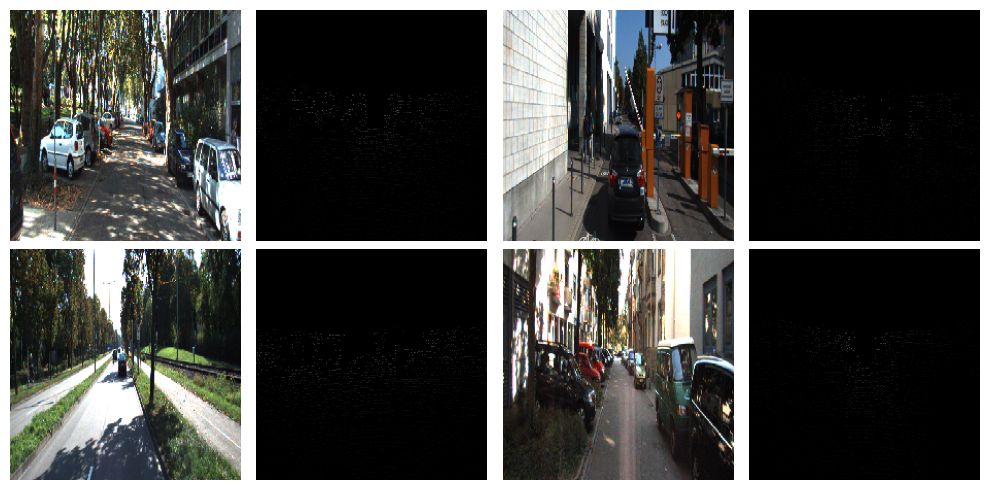

In [ ]:
display_images(x_imgs, y_imgs, rows=rows, cols=cols)

In [ ]:
idx = int(BUFFER_SIZE)

train_x = tf.data.Dataset.list_files(xfiles,shuffle=False)
train_y = tf.data.Dataset.list_files(yfiles,shuffle=False)

train_xy = tf.data.Dataset.zip((train_x, train_y))
train_xy = train_xy.shuffle(buffer_size=idx, reshuffle_each_iteration=True)
train_xy = train_xy.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
train_xy = train_xy.batch(BATCH_SIZE)
train_xy = train_xy.prefetch(buffer_size=tf.data.AUTOTUNE)

idt = int(TEST_SIZE)

test_x = tf.data.Dataset.list_files(testxfiles,shuffle=False)
test_y = tf.data.Dataset.list_files(testyfiles,shuffle=False)

test_xy = tf.data.Dataset.zip((test_x, test_y))
test_xy = test_xy.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
test_xy = test_xy.batch(BATCH_SIZE)
test_xy = test_xy.prefetch(buffer_size=tf.data.AUTOTUNE)

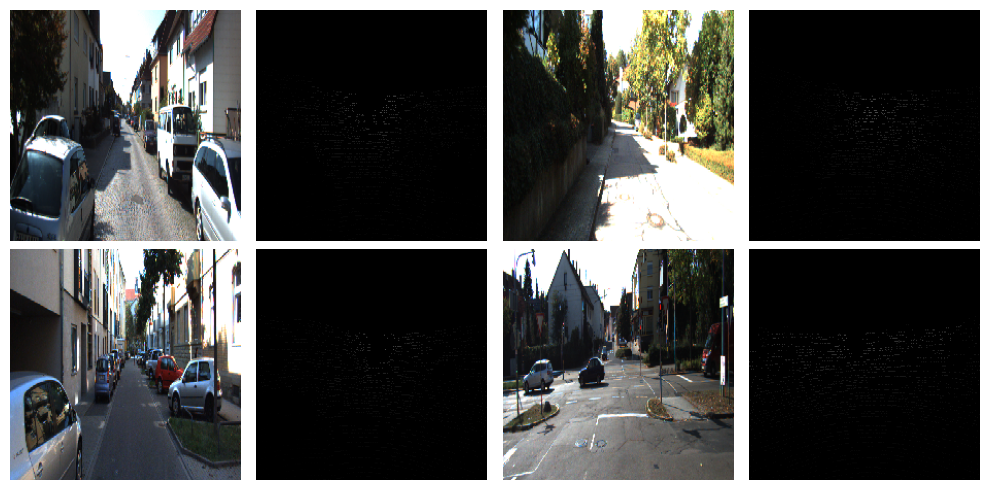

In [ ]:
rows=2
cols=2
for x,y in train_xy.take(1):
    display_images(x, y, rows=rows, cols=cols)
    break

In [ ]:
conv_base=None

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)
conv_base.summary()

58889256/58889256 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Define input tensor
generator_input = layers.Input(shape=input_shape)

# Encoder (using conv_base)
block1_conv1 = conv_base.get_layer('block1_conv1')(generator_input)
block1_conv2 = conv_base.get_layer('block1_conv2')(block1_conv1)
block1_pool = conv_base.get_layer('block1_pool')(block1_conv2)
block2_conv1 = conv_base.get_layer('block2_conv1')(block1_pool)
block2_conv2 = conv_base.get_layer('block2_conv2')(block2_conv1)
block2_pool = conv_base.get_layer('block2_pool')(block2_conv2)
block3_conv1 = conv_base.get_layer('block3_conv1')(block2_pool)
block3_conv2 = conv_base.get_layer('block3_conv2')(block3_conv1)
block3_conv3 = conv_base.get_layer('block3_conv3')(block3_conv2)
block3_pool = conv_base.get_layer('block3_pool')(block3_conv3)
block4_conv1 = conv_base.get_layer('block4_conv1')(block3_pool)
block4_conv2 = conv_base.get_layer('block4_conv2')(block4_conv1)
block4_conv3 = conv_base.get_layer('block4_conv3')(block4_conv2)
block4_pool = conv_base.get_layer('block4_pool')(block4_conv3)
block5_conv1 = conv_base.get_layer('block5_conv1')(block4_pool)
block5_conv2 = conv_base.get_layer('block5_conv2')(block5_conv1)
block5_conv3 = conv_base.get_layer('block5_conv3')(block5_conv2)
block5_pool = conv_base.get_layer('block5_pool')(block5_conv3)

# Decoder
block6_conv1 = layers.Conv2DTranspose(512, (3, 3), activation='sigmoid', padding='same', name='block6_conv1')(block5_pool)
block6_upsamp = layers.UpSampling2D((4, 4),name='block6_upsamp')(block6_conv1)
block7_concat = layers.Concatenate(name='block7_concat')([block6_upsamp, block4_conv3])
block7_conv1 = layers.Conv2DTranspose(128, (3, 3), activation='sigmoid', padding='same',name='block7_conv1')(block7_concat)
block7_conv2 = layers.Conv2DTranspose(128, (3, 3), activation='sigmoid', padding='same',name='block7_conv2')(block7_conv1)
block7_upsamp = layers.UpSampling2D((4, 4),name='block7_upsamp')(block7_conv2)
block8_concat = layers.Concatenate(name='block8_concat')([block7_upsamp, block2_conv2])
block8_conv1 = layers.Conv2DTranspose(32, (3, 3), activation='sigmoid', padding='same',name='block8_conv1')(block8_concat)
block8_upsamp = layers.UpSampling2D((2, 2),name='block8_upsamp')(block8_conv1)
decoded_output = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same',name='decoded_output')(block8_upsamp)  # Output image has 3 channels (RGB)

# Create autoencoder model
generator = models.Model(generator_input, decoded_output)
generator._name = "Generator"

generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[1][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[1][0]']        
                                                                                          

In [ ]:
# Define discriminator model
initializer = tf.random_normal_initializer(0., 0.02)

inp = tf.keras.layers.Input(shape=input_shape, name='input_image')
tar = tf.keras.layers.Input(shape=input_shape, name='target_image')
discriminator_input = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)
discriminator_block1_conv= layers.Conv2D(64, kernel_size=4, strides=2, padding='same',kernel_initializer=initializer)(discriminator_input)
discriminator_block1_norm = layers.BatchNormalization()(discriminator_block1_conv)
discriminator_block1_acti = layers.LeakyReLU()(discriminator_block1_norm)
discriminator_block2_conv = layers.Conv2D(128, kernel_size=4, strides=2, padding='same',kernel_initializer=initializer)(discriminator_block1_acti)
discriminator_block2_norm = layers.BatchNormalization()(discriminator_block2_conv)
discriminator_block2_acti = layers.LeakyReLU()(discriminator_block2_norm)
discriminator_block3_conv = layers.Conv2D(256, kernel_size=4, strides=2, padding='same',kernel_initializer=initializer)(discriminator_block2_acti)
discriminator_block3_norm = layers.BatchNormalization()(discriminator_block3_conv)
discriminator_block3_acti = layers.LeakyReLU()(discriminator_block3_norm)
discriminator_block4_zero = layers.ZeroPadding2D()(discriminator_block3_acti)
discriminator_block4_conv = layers.Conv2D(512, kernel_size=4, strides=2, padding='same',kernel_initializer=initializer)(discriminator_block4_zero)
discriminator_block4_norm = layers.BatchNormalization()(discriminator_block4_conv)
discriminator_block4_acti = layers.LeakyReLU()(discriminator_block4_norm)
discriminator_block5_zero = layers.ZeroPadding2D()(discriminator_block3_acti)
discriminator_block5_conv = layers.Conv2D(1, kernel_size=4, strides=1, padding='same',kernel_initializer=initializer)(discriminator_block5_zero)
discriminator_output = layers.Dense(1, activation='sigmoid')(discriminator_block5_conv)

discriminator = models.Model(inputs=[inp, tar], outputs=discriminator_output)
discriminator._name = "Discriminator"

discriminator.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 224, 224, 6)          0         ['input_image[0][0]',         
                                                                     'target_image[0][0]']        
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         6208      ['concatenate[0][0

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.reduce_mean(losses.binary_crossentropy(tf.ones_like(disc_real_output), disc_real_output))
    generated_loss = tf.reduce_mean(losses.binary_crossentropy(tf.zeros_like(disc_generated_output), disc_generated_output))
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [ ]:
l_1 = 20
l_2 = 5


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.reduce_mean(losses.binary_crossentropy(tf.ones_like(disc_generated_output), disc_generated_output))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(target, gen_output, max_val=255.0))
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (l_1 * ssim_loss) + (l_2 * l1_loss)
    return total_gen_loss, gan_loss, ssim_loss, l1_loss

In [ ]:
generator_optimizer     = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_images(model, x_input, y_input):
    '''
    Con training=True se obtienen las metricas sobre el Lote.
    En otro caso, no se evaluan y se regresan las del entrenamiento.
    '''
    y_pred= model(x_input, training=True)


    plt.figure(figsize=(15, 15))
    display_list = [ y_input[0], x_input[0], y_pred[0]]
    title        = ['Objetivo, $y$', 'Imagen $x$', 'P2P  $\hat{y}$']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        if i<3:
            plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow((display_list[i]+1)/2)
        plt.axis('off')
    plt.show()

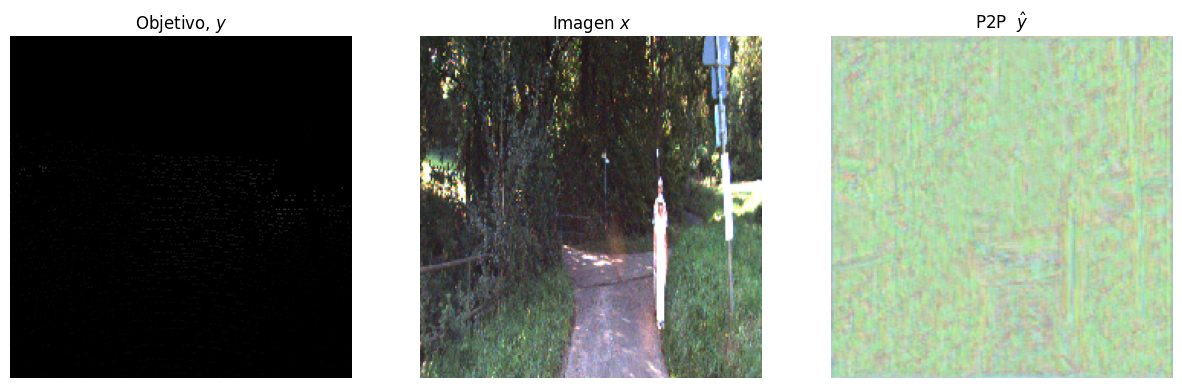

(10, 224, 224, 3) (10, 224, 224, 3)


In [ ]:
for x_input, y_input in train_xy.take(1):
    generate_images(generator, x_input, y_input)
    print(x_input.shape, y_input.shape)
    break

In [ ]:
log_dir="/data_depth_selection/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
    '''
    Cálculos realizados durante un paso del entrenamiento

    Dadas los pares x,y (suavizada, real):
    - Genera datos sintéticos x' con Unet
    - Evalua el discriminador para los pares suavizado-(x,y) y texturizado-(x',y)
    - Evalua los costos del generador y del discriminador
    - Calcula los gradiente
    - Realiza los pasos de optimización
    - Reporta loss y métricas
    '''

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        gen_output = generator(input_image, training=True)

        disc_real_output      = discriminator([input_image, target],     training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_ssim_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients     = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,     discriminator.trainable_variables)

    generator_optimizer.apply_gradients(    zip(generator_gradients,     generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        ss = step//1000
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=ss)
        tf.summary.scalar('gen_gan_loss',   gen_gan_loss,   step=ss)
        tf.summary.scalar('gen_ssim_loss',  gen_ssim_loss,  step=ss)
        tf.summary.scalar('gen_l1_loss',    gen_l1_loss,    step=ss)
        tf.summary.scalar('disc_loss',      disc_loss,      step=ss)

In [ ]:
def fit(train_xy, test_xy, steps):

    # toma un lote, batch de pares (x,y)
    x, y = next(iter(test_xy.take(1)))
    start = time.time()

    for step, (x, y) in train_xy.repeat().take(steps).enumerate():

        # muestra avance en la texturización
        if (step) % 1000 == 0:
            display.clear_output(wait=True)
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()
            generate_images(generator, x,y)
            print(f"Step: {step//1000}k")

        # paso de entrenamiento
        train_step(x, y, step)
        if (step+1) % 10 == 0: print('.', end='', flush=True)

        # Checkpoint every 5k steps
        if (step + 1) % 5000 == 0:
              checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

<IPython.core.display.Javascript object>

Time taken for 1000 steps: 1049.24 sec



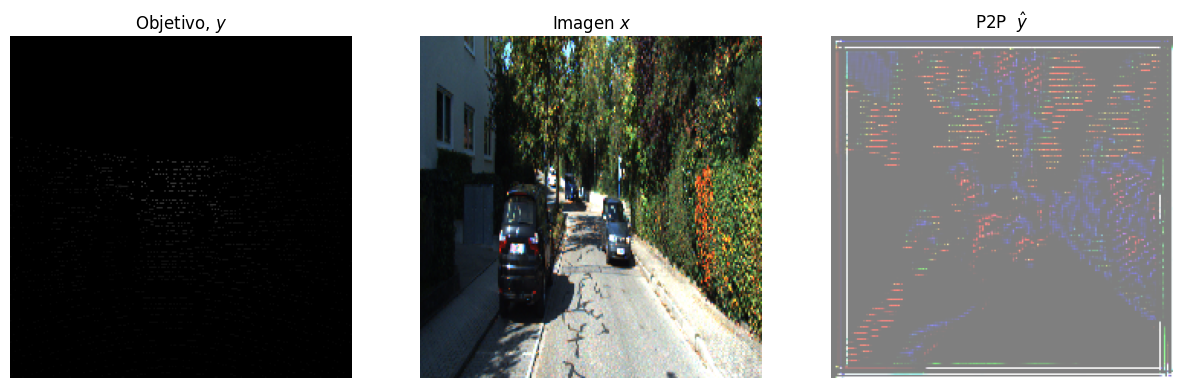

Step: 12k
...........................

In [ ]:
fit(train_xy, test_xy, steps=50001)